In [2]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set()

from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

In [0]:
_INFECTED_IMGSDIR = "data/covid-chestxray-dataset/output/Infected"
_NORMAL_IMGSDIR = "data/covid-chestxray-dataset/output/Normal"

def _parse_image(example_proto):
    features = tf.io.parse_single_example(example_proto, feature_desc)
    image = tf.image.decode_jpeg(features['image'],channels=3)
    image = tf.cast(image , tf.float32) * (1. / 255)
    image = tf.image.resize(image,(200,200))
    label = tf.reshape(features['label'],shape=(1,))

    return image, label

feature_desc = dict(
    label=tf.io.FixedLenFeature([], tf.int64),
    image=tf.io.FixedLenFeature([], tf.string)
)


def _fetchDataset(records_dir):
    tfrecs_dir = os.path.abspath(records_dir)
    for root, _, files in os.walk(tfrecs_dir):
        records = map(
            lambda x: os.path.join(root, x), files)
        records = list(records)
    
    return tf.data.TFRecordDataset(records)


In [9]:
infected_dataset = _fetchDataset(_INFECTED_IMGSDIR)
normal_dataset = _fetchDataset(_NORMAL_IMGSDIR)

full_dataset = infected_dataset.concatenate(normal_dataset)
full_dataset = full_dataset.map(_parse_image)
full_dataset = full_dataset.shuffle(20000)

dataset_size = len(list(full_dataset))
train_size = int(dataset_size * 0.7)
val_size = int(dataset_size * 0.1)
test_size = int(dataset_size * 0.2)

train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

train_dataset,val_dataset,test_dataset

(<TakeDataset shapes: ((200, 200, 3), (1,)), types: (tf.float32, tf.int64)>,
 <SkipDataset shapes: ((200, 200, 3), (1,)), types: (tf.float32, tf.int64)>,
 <TakeDataset shapes: ((200, 200, 3), (1,)), types: (tf.float32, tf.int64)>)

In [0]:
BATCH_SIZE = 2
train_dataset = train_dataset.shuffle(10000)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.cache()
train_dataset = train_dataset.prefetch(8)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [0]:
def create_model(shape):
    model = Sequential()

    # Convolution
    model.add(Conv2D(32, (3, 3), input_shape = shape, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    # Adding a second convolutional layer
    model.add(Conv2D(32, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))

    # Flattening
    model.add(Flatten())

    # Full connection
    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dense(units = 1, activation = 'sigmoid'))
    
    return model

In [0]:
model = create_model(shape=(200, 200, 3))
optimizer = tf.keras.optimizers.Adam()
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              weighted_metrics=['accuracy', 
                                tf.keras.metrics.Precision(),
                                tf.keras.metrics.Recall()]
)


In [0]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
                        "CovidDetector.h5",
                        save_best_only=True,verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(
                        patience=4,verbose=1)


In [0]:
tf.keras.backend.clear_session()

In [15]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=10,
                    callbacks=[checkpoint, early_stopping],
                    verbose=2)


Epoch 1/10

Epoch 00001: val_loss improved from inf to 0.31510, saving model to CovidDetector.h5
184/184 - 23s - loss: 0.5440 - accuracy: 0.8665 - precision: 0.8938 - recall: 0.9355 - val_loss: 0.3151 - val_accuracy: 0.9151 - val_precision: 0.9853 - val_recall: 0.8933
Epoch 2/10

Epoch 00002: val_loss improved from 0.31510 to 0.13760, saving model to CovidDetector.h5
184/184 - 23s - loss: 0.1986 - accuracy: 0.9428 - precision: 0.9674 - recall: 0.9570 - val_loss: 0.1376 - val_accuracy: 0.9340 - val_precision: 1.0000 - val_recall: 0.9079
Epoch 3/10

Epoch 00003: val_loss improved from 0.13760 to 0.09026, saving model to CovidDetector.h5
184/184 - 22s - loss: 0.1132 - accuracy: 0.9809 - precision: 0.9892 - recall: 0.9857 - val_loss: 0.0903 - val_accuracy: 0.9811 - val_precision: 1.0000 - val_recall: 0.9750
Epoch 4/10

Epoch 00004: val_loss improved from 0.09026 to 0.07212, saving model to CovidDetector.h5
184/184 - 22s - loss: 0.1366 - accuracy: 0.9646 - precision: 0.9750 - recall: 0.9785

In [16]:
model.evaluate(val_dataset)

53/53 [==============================] - 0s 7ms/step - loss: 0.0224 - accuracy: 0.9811 - precision: 0.9877 - recall: 0.9877


[0.022423822432756424,
 0.9811320900917053,
 0.9876543283462524,
 0.9876543283462524]

In [0]:
# Save model
# model.save("CovidDetector.h5")

In [8]:
# model = load_model("CovidDetector.h5")
# model

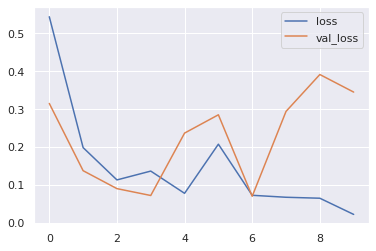

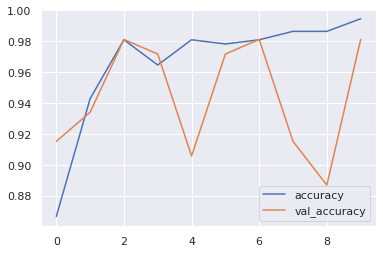

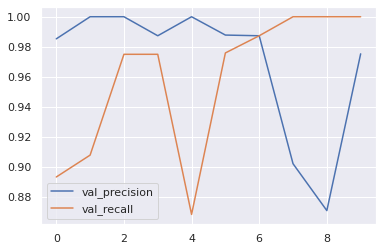

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.show()
plt.plot(history.history['val_precision'])
plt.plot(history.history['val_recall'])
plt.legend(['val_precision','val_recall'])
plt.show()

In [0]:
Y_pred = model.predict(test_dataset)
Y_test = list()
[Y_test.extend(label.numpy().reshape(-1,)) for _, label in test_dataset]
Y_pred = Y_pred.reshape(Y_pred.shape[0])

In [0]:
binary = lambda x: 1 if x > 0.5 else 0
binary = np.vectorize(binary)
Y_pred = binary(Y_pred)

In [24]:
print(accuracy_score(Y_test, Y_pred))
mat = confusion_matrix(Y_test, Y_pred)
print(mat)

0.6476190476190476
[[ 4 18]
 [19 64]]


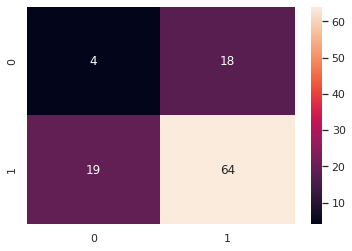

In [25]:
sns.heatmap(mat, annot=True)

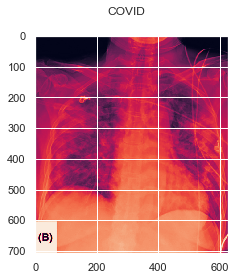

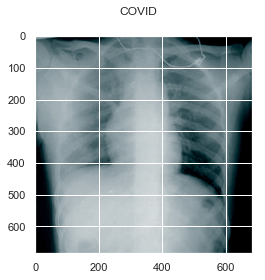

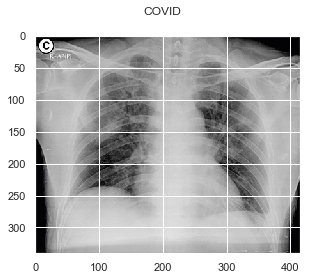

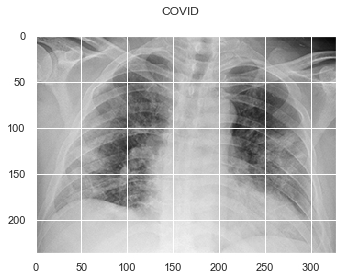

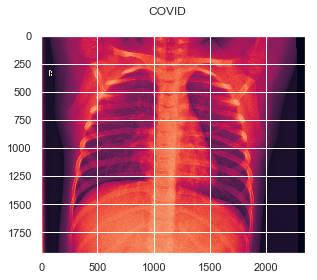

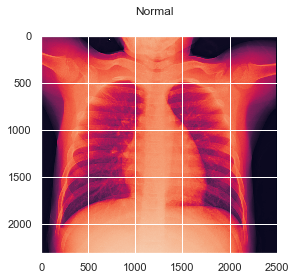

In [10]:
vis_dir = "data/covid-chestxray-dataset/visImages"

for img_file in os.listdir(vis_dir):
    img_src = os.path.join(vis_dir, img_file)
    img_pred = cv2.imread(img_src)
    img_pred = cv2.resize(img_pred, (200, 200))

    img_pred = np.expand_dims(img_pred, axis = 0)
    rslt = model.predict(img_pred)

    if rslt[0][0] == 0:
        prediction = "Normal"
    else:
        prediction = "COVID"

    target_width = 50
    target_height = 50
    target_size = (target_width, target_height)

    img_pred = np.squeeze(img_pred)
    img = cv2.resize(img_pred, target_size)
    img = img.reshape(1, target_width, target_height, 3)

    fig, ax = plt.subplots()
    fig.suptitle(prediction, fontsize=12)

    np_img = mpimg.imread(img_src)
    plt.imshow(np_img)
    plt.show()
